In [105]:
import pandas as pd 
import os
import numpy as np

In [106]:
# check file names
files = os.listdir(os.curdir) 
files

['.ipynb_checkpoints',
 'Complete - Merge Footfall data - hourly.ipynb',
 'feb18I.csv',
 'feb18I_unixtime.csv',
 'feb18I_unixtime_1h.csv',
 'feb18I_unixtime_5min.csv',
 'feb_central_footfall.csv',
 'feb_footfall.csv',
 'feb_map_footfall.csv',
 'feb_map_footfall_final.csv',
 'installs.csv',
 'locations.csv',
 'locations_lonlat.csv',
 'mar18I.csv',
 'mar18I_unixtime.csv',
 'Stratford.ipynb']

In [107]:
feb18I = pd.read_csv('feb18I.csv', sep = ',', names = ["device", "day", "hour", "minute", "count"])
print(feb18I.head(1))
print(feb18I.count())

   device  day  hour  minute  count
0     749    1     0       0   28.0
device    1048576
day       1048576
hour      1048576
minute    1048576
count     1048576
dtype: int64


In [108]:
feb18I_5min = feb18I.copy()
#mar18I_5min = mar18I.copy()

conditions = [(feb18I_5min.hour <= 6)|(feb18I_5min.hour >= 18)]
choices = [1]
feb18I_5min["night"] = np.select(conditions, choices, default = -1) # 1 for night | -1 for day

In [109]:
print(feb18I_5min.head())

   device  day  hour  minute  count  night
0     749    1     0       0   28.0      1
1     749    1     0       5   22.0      1
2     749    1     0      10   17.0      1
3     749    1     0      15   30.0      1
4     749    1     0      20   49.0      1


In [110]:
# create timestamp 
from datetime import datetime
from pytz import timezone
import pytz

In [111]:
pd.options.mode.chained_assignment = None

In [112]:
# TEST FOR LOOP TIME CONSUMED
# seems that for loop for 1M rows shouldn't be the main problem here
# temp = []
# for i in range(1, len(feb18I_new.index)+1):
#     temp.append(i*2)

Below is running time for various time stripping functions. "strptime" is ...notablly slow. If we know how the time is formatted, can try with "datetime" function instead.

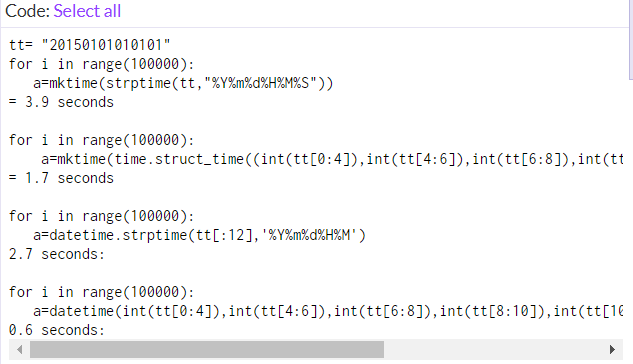

### EXTRACT UNIXTIME

#### February

In [113]:
feb18I_5min['timestamp'] = None

In [114]:
# convert the pandas columns to numpy arrays as Series slicing is much slower than np
day = feb18I_5min.day.values
hour = feb18I_5min.hour.values
minute = feb18I_5min.minute.values

In [115]:
timestamp = []
for i in range(len(feb18I_5min.index)):
    timestamp.append(datetime(2018,2,day[i],hour[i],minute[i]))

In [116]:
# check
print(len(feb18I_5min.index))
print(len(timestamp))

1048576
1048576


In [117]:
# add the column back to the dataframe
feb18I_5min['timestamp'] = pd.Series(timestamp, index=feb18I_5min.index)

In [118]:
# check
feb18I_5min.head(5)

,device,day,hour,minute,count,night,timestamp
0,749,1,0,0,28.0,1,2018-02-01 00:00:00
1,749,1,0,5,22.0,1,2018-02-01 00:05:00
2,749,1,0,10,17.0,1,2018-02-01 00:10:00
3,749,1,0,15,30.0,1,2018-02-01 00:15:00
4,749,1,0,20,49.0,1,2018-02-01 00:20:00


In [119]:
### GET HOURLY DATA ###
feb18I_1h = feb18I_5min.copy()
feb18I_1h = feb18I_1h.drop(['day','hour','minute'], axis=1)
feb18I_1h = feb18I_1h.set_index("timestamp")

# create an empty dataframe
feb18I_1h_temp = pd.DataFrame(columns = feb18I_1h.columns)

# get device ids from data
device_id = feb18I_5min.device.unique()

In [120]:
feb18I_1h.head()

,device,count,night
timestamp,,,
2018-02-01 00:00:00,749,28.0,1
2018-02-01 00:05:00,749,22.0,1
2018-02-01 00:10:00,749,17.0,1
2018-02-01 00:15:00,749,30.0,1
2018-02-01 00:20:00,749,49.0,1


In [121]:
device_id

array([749, 750, 751, 752, 753, 754, 755, 756, 763, 764, 765, 767, 768,
       769, 770, 772, 774, 775, 776, 778, 779, 780, 784, 785, 787, 790,
       791, 792, 793, 794, 795, 796, 797, 799, 800, 801, 802, 806, 807,
       809, 810, 811, 812, 813, 815, 816, 817, 819, 820, 822, 823, 825,
       826, 828, 829, 830, 831, 836, 839, 841, 842, 844, 847, 848, 849,
       850, 852, 854, 856, 857, 858, 859, 861, 862, 863, 864, 865, 867,
       872, 874, 875, 876, 877, 880, 881, 883, 884, 885, 886, 887, 889,
       891, 892, 893, 895, 898, 899, 901, 902, 905, 906, 909, 914, 916,
       918, 920, 921, 922, 924, 925, 926, 927, 928, 930, 933, 934, 936,
       937, 938, 941, 944, 946, 947, 948, 949, 951, 952, 953, 956, 957,
       959, 960, 961, 964, 965], dtype=int64)

In [122]:
# loop through device ids, and aggregate the data by hour
for id in device_id:
    #create a subset of this id's data
    df_temp = feb18I_1h.loc[feb18I_1h.device == id]
    df_temp_1h = df_temp.resample('1H').agg({'count':'mean','device':'mean', 'night': 'mean'})
    feb18I_1h_temp = pd.concat([feb18I_1h_temp,df_temp_1h])
    
feb18I_1h_temp = feb18I_1h_temp.dropna()
feb18I_1h_temp.head(7)

,count,device,night
2018-02-01 00:00:00,23.583333,749,1
2018-02-01 01:00:00,12.416667,749,1
2018-02-01 02:00:00,10.083333,749,1
2018-02-01 03:00:00,6.166667,749,1
2018-02-01 04:00:00,7.416667,749,1
2018-02-01 05:00:00,13.833333,749,1
2018-02-01 06:00:00,24.166667,749,1


In [123]:
# convert timestamp to unixtime -5min
feb18I_5min['unixtime'] = None

unixtime = []
for i in range(len(feb18I_5min.index)):
    unixtime.append(timestamp[i].timestamp())
    
feb18I_5min['unixtime'] = pd.Series(unixtime, index = feb18I_5min.index)
feb18I_5min.head()

,device,day,hour,minute,count,night,timestamp,unixtime
0,749,1,0,0,28.0,1,2018-02-01 00:00:00,1.517443e+09
1,749,1,0,5,22.0,1,2018-02-01 00:05:00,1.517444e+09
2,749,1,0,10,17.0,1,2018-02-01 00:10:00,1.517444e+09
3,749,1,0,15,30.0,1,2018-02-01 00:15:00,1.517444e+09
4,749,1,0,20,49.0,1,2018-02-01 00:20:00,1.517444e+09


In [124]:
# convert timestamp to unixtime -1h
feb18I_1h_temp['unixtime'] = None
unixtime = []

timestamp = feb18I_1h_temp.index

for i in range(len(feb18I_1h_temp.index)):
    unixtime.append(timestamp[i].timestamp())
    
feb18I_1h_temp['unixtime'] = pd.Series(unixtime, index = feb18I_1h_temp.index)
feb18I_1h_temp.head()

,count,device,night,unixtime
2018-02-01 00:00:00,23.583333,749,1,1.517443e+09
2018-02-01 01:00:00,12.416667,749,1,1.517447e+09
2018-02-01 02:00:00,10.083333,749,1,1.517450e+09
2018-02-01 03:00:00,6.166667,749,1,1.517454e+09
2018-02-01 04:00:00,7.416667,749,1,1.517458e+09


In [125]:
### MERGING DATA ###

installs = pd.read_csv('installs.csv', sep = ',')
installs.head(1)

,id,device,location,startdate,enddate,height,depth,note
0,40,83,1,10/27/2015,11/9/2016,NaN,NaN,Near customer seating. May be unplugged by cu...


In [126]:
locations = pd.read_csv('locations_lonlat.csv', sep = ',')
locations.head(1)

,Unnamed: 0,id,location,address,city,region,postcode,longitude,latitude
0,13,40,0101000000E31934F44F70A13FA2EE0390DAC44940,"Unit 4, St. Stephens Parade, Green Street, Lon...",London,Greater London,E7 8LQ,0.034213,51.537992


In [127]:
locations.isnull().sum()

Unnamed: 0    0
id            0
location      0
address       0
city          0
region        0
postcode      0
longitude     0
latitude      0
dtype: int64

In [128]:
installs.isnull().sum()

id             0
device         0
location       0
startdate      0
enddate      879
height       427
depth        427
note         718
dtype: int64

In [129]:
# for the first merge: locations, installs
# removed what is not part of london from locations using the geo-coding file
# therefore joining left on locations 

In [130]:
locations.rename(columns = {'id':'location_id'}, inplace = True)
installs.rename(columns = {'location':'location_id'}, inplace = True)

In [131]:
locations_relevant = pd.DataFrame(locations, columns=['location_id', 'longitude', 'latitude'])
installs_relevant = pd.DataFrame(installs, columns=['device', 'location_id'])

In [132]:
installs_locations = pd.merge(locations_relevant, installs_relevant, on = "location_id", how = 'inner')

In [133]:
# for some location_id there is a long lat and no device, therefore inner join instead of left join, otherwise
# there will be values with device NaN

In [134]:
locations_relevant[locations_relevant["location_id"] == 640]

,location_id,longitude,latitude
15,640,-0.055747,51.416228


In [135]:
installs_relevant[installs_relevant["location_id"] == 640]

,device,location_id


In [136]:
installs_locations.head(1)

,location_id,longitude,latitude,device
0,40,0.034213,51.537992,15


In [137]:
installs_locations.isnull().sum()
# inner join instead of left joi, otherwise few missing for device

location_id    0
longitude      0
latitude       0
device         0
dtype: int64

In [138]:
# merging month using device variable

In [139]:
feb18I.isnull().sum()

device    0
day       0
hour      0
minute    0
count     0
dtype: int64

In [140]:
# merge 5min data
feb18I_5min_new = pd.merge(installs_locations, feb18I_5min, on = "device", how = 'inner')

In [141]:
# merge 1h data
feb18I_1h_new = pd.merge(installs_locations, feb18I_1h_temp, on = "device", how = 'inner')

In [142]:
feb18I_1h_new.isnull().sum()

location_id    0
longitude      0
latitude       0
device         0
count          0
night          0
unixtime       0
dtype: int64

In [143]:
feb18I_1h_new[feb18I_1h_new['device'] == 15]

,location_id,longitude,latitude,device,count,night,unixtime


In [144]:
installs_locations[installs_locations['device'] == 15]

,location_id,longitude,latitude,device
0,40,0.034213,51.537992,15


In [145]:
#-0.1446 / -0.1194
#51.5062 / 51.5164

conditions = [
    (feb18I_1h_new["latitude"] >= 51.4966) & (feb18I_1h_new["latitude"] <= 51.5287) & (feb18I_1h_new["longitude"] <= -0.1121) & (feb18I_1h_new["longitude"] >= -0.1754)
]

choices = [1]
feb18I_1h_new["central"] = np.select(conditions, choices, default = -1) # 1 for central | -1 for out of central ldn

In [146]:
#-0.1446 / -0.1194
#51.5062 / 51.5164

conditions = [
    (feb18I_5min_new["latitude"] >= 51.4966) & (feb18I_5min_new["latitude"] <= 51.5287) & (feb18I_5min_new["longitude"] <= -0.1121) & (feb18I_5min_new["longitude"] >= -0.1754)
]

choices = [1]
feb18I_5min_new["central"] = np.select(conditions, choices, default = -1) # 1 for central | -1 for out of central ldn

In [147]:
feb18I_5min_new = feb18I_5min_new[feb18I_5min_new.central == 1]

In [148]:
feb18I_1h_new = feb18I_1h_new[feb18I_1h_new.central == 1]

In [149]:
# not for every device a match in the feb and march file
# possible that no count available for that time/day
# since locations filtered for London in the locations file
# inner join 

In [150]:
print(len(feb18I_5min_new))
print(len(feb18I_1h_new))

214730
17928


In [151]:
feb18I_5min_new.head()

,location_id,longitude,latitude,device,day,hour,minute,count,night,timestamp,unixtime,central
40321,102,-0.119758,51.517486,750,1,0,0,14.833,1,2018-02-01 00:00:00,1.517443e+09,1
40322,102,-0.119758,51.517486,750,1,0,5,17.139,1,2018-02-01 00:05:00,1.517444e+09,1
40323,102,-0.119758,51.517486,750,1,0,10,17.000,1,2018-02-01 00:10:00,1.517444e+09,1
40324,102,-0.119758,51.517486,750,1,0,15,18.000,1,2018-02-01 00:15:00,1.517444e+09,1
40325,102,-0.119758,51.517486,750,1,0,20,12.000,1,2018-02-01 00:20:00,1.517444e+09,1


In [152]:
feb18I_1h_new.head()

,location_id,longitude,latitude,device,count,night,unixtime,central
3360,102,-0.119758,51.517486,750,12.081000,1,1.517443e+09,1
3361,102,-0.119758,51.517486,750,15.000000,1,1.517447e+09,1
3362,102,-0.119758,51.517486,750,7.466825,1,1.517450e+09,1
3363,102,-0.119758,51.517486,750,2.785877,1,1.517454e+09,1
3364,102,-0.119758,51.517486,750,1.158344,1,1.517458e+09,1


In [155]:
feb18I_5min_new.unixtime = feb18I_5min_new.unixtime.astype(int)
feb18I_1h_new.unixtime = feb18I_1h_new.unixtime.astype(int)

In [156]:
feb18I_5min_new.to_csv("feb18I_unixtime_5min.csv", index = False, header = True)

In [154]:
#feb18I_1h_new.to_csv("feb18I_unixtime_1h.csv", index = False, header = True)